In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import os
import math
import json
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def __save_model(model_name, model, root):
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    torch.save(model.state_dict(), p)
    return p

def save_model(models, root='./model'):
    p = {}
    for k, m in models.items():
        p[k] = __save_model(k, m, root)
    return p

def __load_model(model_name, model, root):
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    if not os.path.isfile(p):
        msg = "No model parameters file for {}!".format(model_name)
        return print(msg)
        raise AttributeError(msg)
    paras = torch.load(p)
    model.load_state_dict(paras)

def load_model(models, root='./model'):
    for k, m in models.items():
        __load_model(k, m, root)
        
def save_model_by_score(models, bleu_score, root):
    p = os.path.join(root, 'score.json')
    previous = None
    
    if np.isnan(bleu_score):
        raise AttributeError("BLEU score become {}".format(bleu_score))
        return
    
    if os.path.isfile(p):
        with open(p, 'r') as f:
            previous = json.load(f)
            
    if previous is not None and previous['score'] > bleu_score:
        return;
    
    save_model(models, root)
    previous = {'score' : bleu_score}
    with open(p, 'w') as f:
        json.dump(previous, f)

In [4]:
class CharDict:
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.n_words = 0
        
        for i in range(26):
            self.addWord(chr(ord('a') + i))
        
        tokens = ["SOS", "EOS"]
        for t in tokens:
            self.addWord(t)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

    def longtensorFromString(self, s):
        s = ["SOS"] + list(s) + ["EOS"]
        return torch.LongTensor([self.word2index[ch] for ch in s])
    
    def stringFromLongtensor(self, l, show_token=False, check_end=True):
        s = ""
        for i in l:
            ch = self.index2word[i.item()]
            if len(ch) > 1:
                if show_token:
                    __ch = "<{}>".format(ch)
                else:
                    __ch = ""
            else:
                __ch = ch
            s += __ch
            if check_end and ch == "EOS":
                break
        return s

class wordsDataset(Dataset):
    def __init__(self, train=True):
        if train:
            f = './train.txt'
        else:
            f = './test.txt'
        self.datas = np.loadtxt(f, dtype=np.str)
        
        if train:
            self.datas = self.datas.reshape(-1)
        else:
            '''
            sp -> p
            sp -> pg
            sp -> tp
            sp -> tp
            p  -> tp
            sp -> pg
            p  -> sp
            pg -> sp
            pg -> p
            pg -> tp
            '''
            self.targets = np.array([
                [0, 3],
                [0, 2],
                [0, 1],
                [0, 1],
                [3, 1],
                [0, 2],
                [3, 0],
                [2, 0],
                [2, 3],
                [2, 1],
            ])
        
        #self.tenses = ['sp', 'tp', 'pg', 'p']
        self.tenses = [
            'simple-present', 
            'third-person', 
            'present-progressive', 
            'simple-past'
        ]
        self.chardict = CharDict()
        
        self.train = train
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, index):
        if self.train:
            c = index % len(self.tenses)
            return self.chardict.longtensorFromString(self.datas[index]), c
        else:
            i = self.chardict.longtensorFromString(self.datas[index, 0])
            ci = self.targets[index, 0]
            o = self.chardict.longtensorFromString(self.datas[index, 1])
            co = self.targets[index, 1]
            
            return i, ci, o, co

In [20]:
#Encoder
class EncoderRNN(nn.Module):
    def __init__(
        self, word_size, hidden_size, latent_size, 
        num_condition, condition_size
    ):
        super(EncoderRNN, self).__init__()
        self.word_size = word_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.latent_size = latent_size

        self.condition_embedding = nn.Embedding(num_condition, condition_size)
        self.word_embedding = nn.Embedding(word_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, latent_size)
        self.logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, inputs, init_hidden, input_condition):
        c = self.condition(input_condition)
        
        # get (1,1,hidden_size)
        hidden = torch.cat((init_hidden, c), dim=2)
        
        # get (seq, 1, hidden_size)
        x = self.word_embedding(inputs).view(-1, 1, self.hidden_size)
        x = F.relu(x)
        # get (seq, 1, hidden_size), (1, 1, hidden_size)
        outputs, hidden = self.gru(x, hidden)
        
        # get (1, 1, hidden_size)
        m = self.mean(hidden)
        logvar = self.logvar(hidden)
        
        z = self.sample_z() * torch.exp(logvar/2) + m
        
        #self.m = m
        #self.logvar = logvar
        
        return z, m, logvar

    def initHidden(self):
        return torch.zeros(
            1, 1, self.hidden_size - self.condition_size, 
            device=device
        )
    
    def condition(self, c):
        c = torch.LongTensor([c]).to(device)
        return self.condition_embedding(c).view(1,1,-1)
    
    def sample_z(self):
        return torch.normal(
            torch.FloatTensor([0]*self.latent_size), 
            torch.FloatTensor([1]*self.latent_size)
        ).to(device)

In [21]:
#Decoder
class DecoderRNN(nn.Module):
    def __init__(
        self, word_size, hidden_size, latent_size, condition_size
    ):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.word_size = word_size

        self.latent_to_hidden = nn.Linear(
            latent_size+condition_size, hidden_size
        )
        self.word_embedding = nn.Embedding(word_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, word_size)
        
    def forward(self, inputs, z, c, teacher=False, hidden=None):
        # get (1,1,latent_size + condition_size)
        latent = torch.cat((z, c), dim=2)
        
        # get (1,1,hidden_size)
        if hidden is None:
            hidden = self.latent_to_hidden(latent)
            #print("get hidden from latent")
        
        # get (seq, 1, hidden_size)
        x = self.word_embedding(inputs).view(-1, 1, self.hidden_size)
        #x = F.relu(x)
        input_length = x.size(0)
        
        # get (seq, 1, hidden_size), (1, 1, hidden_size)
        if teacher:
            outputs = []
            for i in range(input_length-1):
                output, hidden = self.gru(x[i:i+1], hidden)
                hidden = x[i+1:i+2]
                outputs.append(output)
            
            outputs = torch.cat(outputs, dim=0)
        else:
            # Omit EOS token
            x = x[:-1]
            outputs, hidden = self.gru(x, hidden)
            
        # get (seq, word_size)
        outputs = self.out(outputs).view(-1, self.word_size)
        
        return outputs, hidden

In [70]:
# config

train_dataset = wordsDataset()
test_dataset = wordsDataset(False)

word_size = train_dataset.chardict.n_words
num_condition = len(train_dataset.tenses)

hidden_size = 256
latent_size = 32
condition_size = 8
teacher_forcing_ratio = 0.5
KLD_weight = 0.0
LR = 0.05

In [71]:
encoder = EncoderRNN(
    word_size, hidden_size, latent_size, num_condition, condition_size
).to(device)
decoder = DecoderRNN(
    word_size, hidden_size, latent_size, condition_size
).to(device)
encoder, decoder

(EncoderRNN(
   (condition_embedding): Embedding(4, 8)
   (word_embedding): Embedding(28, 256)
   (gru): GRU(256, 256)
   (mean): Linear(in_features=256, out_features=32, bias=True)
   (logvar): Linear(in_features=256, out_features=32, bias=True)
 ),
 DecoderRNN(
   (latent_to_hidden): Linear(in_features=40, out_features=256, bias=True)
   (word_embedding): Embedding(28, 256)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=28, bias=True)
 ))

In [72]:
load_model(
    {'encoder':encoder, 'decoder':decoder}, 
    os.path.join('.', 'best')
)

In [15]:
#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    return sentence_bleu(
        [reference], output,
        weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=cc.method1
    )

def evaluation(encoder, decoder, dataset,show=True):
    encoder.eval()
    decoder.eval()
    
    char_accuracy_total = 0
    char_accuracy_len = 0
    
    blue_score = []
    
    for idx in range(len(dataset)):
        data = dataset[idx]
        if dataset.train:
            inputs, input_condition = data
            targets = inputs
            target_condition = input_condition
        else:
            inputs, input_condition, targets, target_condition = data
            
        # input no sos and eos
        z, _, _ = encoder(inputs[1:-1].to(device), encoder.initHidden(), input_condition)
            
        # input has sos
        outputs, _ = decoder(targets.to(device), z, encoder.condition(target_condition), False)
            
        # show output by string
        outputs_onehot = torch.max(torch.softmax(outputs, dim=1), 1)[1]
        inputs_str = train_dataset.chardict.stringFromLongtensor(inputs, check_end=True)
        targets_str = train_dataset.chardict.stringFromLongtensor(targets, check_end=True)
        outputs_str = train_dataset.chardict.stringFromLongtensor(outputs_onehot, check_end=True)
        
        if show:
            print(inputs_str, '->', targets_str,':',outputs_str)
            
        char_accuracy_total += (outputs_onehot[:-1] == targets[1:-1].to(device)).sum().item()
        char_accuracy_len += len(targets[1:-1])
        
        blue_score.append( compute_bleu(outputs_str, targets_str) )
    
    if show:
        print('Accuracy per char : {}'.format(char_accuracy_total / char_accuracy_len))
        print('BLEU-4 score : {}'.format(sum(blue_score) / len(blue_score)))
    
    return blue_score

In [47]:
def KLD_weight_annealing(*args):
    epoch, batch = args
    slope = 0.001
    #slope = 0.1
    scope = (1.0 / slope)*2
    
    w = (epoch % scope) * slope
    
    if w > 1.0:
        w = 1.0
    
    return w

In [11]:
def Gaussian_score(words):
    words_list = []
    score = 0
    yourpath = '/home/ubuntu/DL/train.txt'#should be your directory of train.txt
    with open(yourpath,'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            words_list.extend([word])
        for t in words:
            for i in words_list:
                if t == i:
                    score += 1
    return score/len(words)

In [187]:
%reset -f

In [68]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '{:4d}m {:2d}s'.format(int(m), int(s))


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def KL_loss(m, logvar):
    return torch.sum(0.5 * (-logvar + (m**2) + torch.exp(logvar) - 1))
    #return -0.5 * torch.sum(1 + logvar - m.pow(2) - logvar.exp())

def Train(
    name, encoder, decoder, epoch_size, learning_rate=0.01,
    show_size=1000, KLD_weight=0, teacher_forcing_ratio = 0.5, eval_size=100
):  
    start = time.time()
    plots = []
    show_loss_total = 0
    plot_loss_total = 0
    plot_kl_loss_total = 0
    char_accuracy_total = 0
    char_accuracy_len = 0
    plot_teacher = 0
    kld_w = 0.0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.CrossEntropyLoss(reduction='sum')

    for epoch in range(epoch_size):
        encoder.train()
        decoder.train()
        
        # get data from trian dataset
        for idx in range(len(train_dataset)):   
        #for idx in range(1):
            data = train_dataset[idx]
            inputs, c = data
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            # input no sos and eos
            z, m, logvar = encoder(inputs[1:-1].to(device), encoder.initHidden(), c)
            
            # decide teacher forcing
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            
            # input has sos
            outputs, _ = decoder(inputs.to(device), z, encoder.condition(c), use_teacher_forcing)
            
            # target no sos
            loss = criterion(outputs, inputs[1:].to(device))
            kld_loss = KL_loss(m, logvar)
            #loss = criterion(outputs, inputs[:-1].to(device))
            if callable(KLD_weight):
                kld_w = KLD_weight(epoch, idx)
            else:
                kld_w = KLD_weight
                
            #print('crossentropy : {} , kld : {}'.format(loss.item(), kld_loss.item()))
                
            (loss + (kld_w * kld_loss)).backward()
            
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            show_loss_total += loss.item() + ( kld_w*kld_loss.item() )
            plot_loss_total += loss.item()
            plot_kl_loss_total += kld_loss.item()
            
            # show output by string
            # outputs_onehot = torch.max(outputs, 1)[1]
            outputs_onehot = torch.max(torch.softmax(outputs, dim=1), 1)[1]
            inputs_str = train_dataset.chardict.stringFromLongtensor(inputs, show_token=True)
            outputs_str = train_dataset.chardict.stringFromLongtensor(outputs_onehot, show_token=True)
            #print(inputs_str,':',outputs_str)
            
            char_accuracy_total += (outputs_onehot[:-1] == inputs[1:-1].to(device)).sum().item()
            char_accuracy_len += len(inputs[1:-1])
        
        plot_teacher = teacher_forcing_ratio
        score = 0
        for _ in range(eval_size):
            all_score = evaluation(encoder, decoder, test_dataset, show=False)
            score += sum(all_score) / len(all_score)
        score /= eval_size
        
        save_model_by_score(
            {'encoder':encoder, 'decoder':decoder}, 
            score, 
            os.path.join('.', name)
        )
        
        if (epoch + 1)%show_size == 0:
            show_loss_total /= show_size
            print("{} ({} {}%) \ntotal loss : {:.4f}".format(
                timeSince(start, (epoch+1) / epoch_size),
                epoch+1, (epoch+1)*100/epoch_size, show_loss_total
            ))
            print('bleu score : {:.5f}\n'.format(score))
            show_loss_total = 0
        
        plots.append((plot_loss_total, plot_kl_loss_total, kld_w, score, plot_teacher))
        
        plot_loss_total = 0
        plot_kl_loss_total = 0
        char_accuracy_total = 0
        char_accuracy_len = 0
        plot_teacher = 0
        
    return plots

In [69]:
metrics = Train(
    'training', 
    encoder, decoder, 
    epoch_size=200, show_size=50, 
    KLD_weight=KLD_weight_annealing, teacher_forcing_ratio=0.5
)

  70m 41s (-  212m  5s) (50 25.0%) 
total loss : nan
bleu score : 0.01307



KeyboardInterrupt: 

In [57]:
save_model({'encoder':encoder, 'decoder':decoder}, 
    os.path.join('.', 'best'))

{'encoder': './best/encoder-params.pkl',
 'decoder': './best/decoder-params.pkl'}

In [78]:
all_score = evaluation(encoder, decoder, test_dataset)

abandon -> abandoned : abaddoned
abet -> abetting : atstting
begin -> begins : begins
expend -> expends : experes
sent -> sends : sents
split -> splitting : splitting
flared -> flare : frardd
functioning -> function : funct
functioning -> functioned : funiheon
healing -> heals : heavi
Accuracy per char : 0.7777777777777778
BLEU-4 score : 0.491520510501831


In [38]:
def generate_word(encoder, decoder, z, condition, maxlen=20):
    encoder.eval()
    decoder.eval()
    z = z.view(1,1,-1)
    sos_token = train_dataset.chardict.word2index['SOS']
    eos_token = train_dataset.chardict.word2index['EOS']
    inputs = torch.LongTensor([sos_token, eos_token])
    outputs = []
    i = 0
    hidden = None
    
    while True:
        # get (1, word_size)
        output, hidden = decoder(
            inputs.to(device), 
            z.to(device), 
            encoder.condition(condition),
            False,
            hidden
        )
        output_onehot = torch.max(torch.softmax(output, dim=1), 1)[1]
        if output_onehot.item() == eos_token:
            break
        
        outputs.append(output_onehot.item())
        i += 1
        if maxlen <= i:
            break
        
        inputs = torch.LongTensor([outputs[-1], eos_token])
        
    return torch.LongTensor(outputs)

In [82]:
g_score=[]
for j in range(10):
    noise = encoder.sample_z()
    temp=[]
    for i in range(len(train_dataset.tenses)):
        outputs = generate_word(encoder, decoder, noise, i)
        output_str = train_dataset.chardict.stringFromLongtensor(outputs)
        temp.append(output_str)
        print('{:20s} : {}'.format(train_dataset.tenses[i],output_str))
    g_score.append(temp)
    print('\n')
gaussian_score = Gaussian_score(g_score)
print(gaussian_score)

simple-present       : leach
third-person         : shealds
present-progressive  : leaching
simple-past          : leached


simple-present       : red
third-person         : redoms
present-progressive  : redoing
simple-past          : redo


simple-present       : chelate
third-person         : chelates
present-progressive  : felging
simple-past          : felget


simple-present       : solt
third-person         : sounts
present-progressive  : soupting
simple-past          : soltering


simple-present       : fowint
third-person         : fowings
present-progressive  : fowing
simple-past          : fowing


simple-present       : wrett
third-person         : wrettracts
present-progressive  : wrettracting
simple-past          : wrettrated


simple-present       : coide
third-person         : coides
present-progressive  : coisunating
simple-past          : couride


simple-present       : buffin
third-person         : buffings
present-progressive  : buffing
simple-past          : buffi

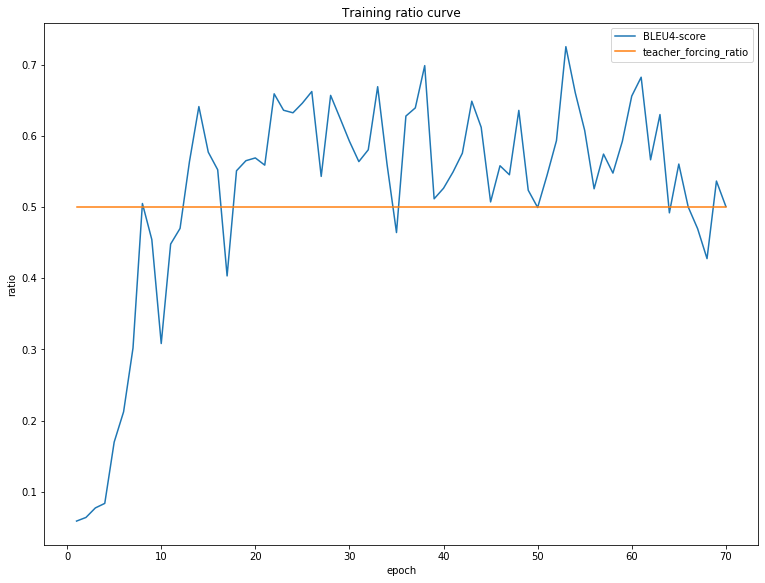

In [44]:
X=list(range(1, 71))
bleu_score=[]
teacher_forcing_ratio=[]
for i in range(len(X)):    
    bleu_score.append(metrics[i][3])
    teacher_forcing_ratio.append(metrics[i][4])
plt.figure(figsize=(12.8, 9.6))
plt.title("Training ratio curve")
plt.ylabel("ratio") 
plt.xlabel("epoch")
plt.plot(X,bleu_score,label='BLEU4-score')
plt.plot(X,teacher_forcing_ratio,label='teacher_forcing_ratio')
plt.legend()
plt.show()

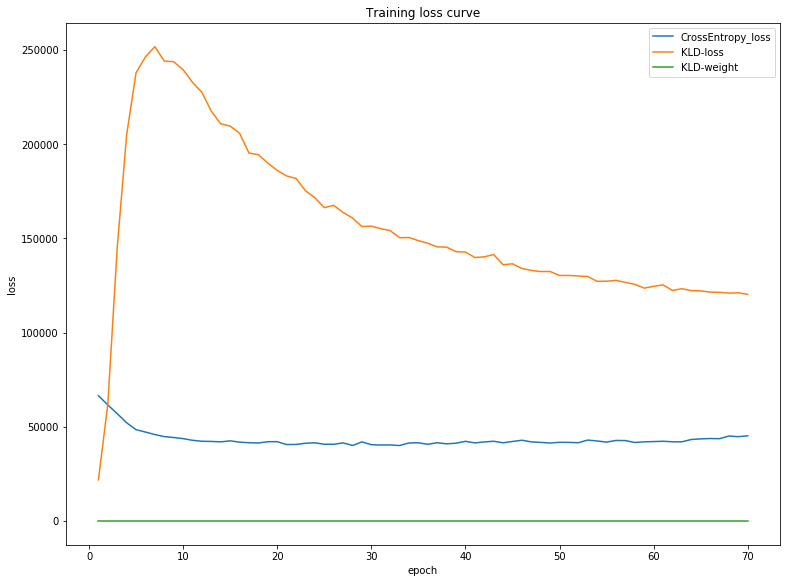

In [45]:
#plot_loss_total, plot_kl_loss_total, kld_w, score
X=list(range(1, 71))
KLloss=[]
KLweight=[]
CrossEntropy_loss=[]
for i in range(len(X)):    
    KLloss.append(metrics[i][1])
    KLweight.append(metrics[i][2]) 
    CrossEntropy_loss.append(metrics[i][0])
    
plt.figure(figsize=(12.8, 9.6))
plt.title("Training loss curve")
plt.ylabel("loss") 
plt.xlabel("epoch")
plt.plot(X,CrossEntropy_loss, label='CrossEntropy_loss')
plt.plot(X,KLloss,label='KLD-loss')
plt.plot(X,KLweight,label='KLD-weight')
plt.legend()
plt.show()